# Dataset preparation

In this section MNIST dataset is used. I define [here](https://github.com/JackVittori/QML-early_exit/blob/main/data_utils.py) a class in order to preprocess it and select the labels you want. 

In [1]:
import torch
import pennylane as qml
from pennylane import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from data_utils import mnist_preparation 
from evaluationUtils import calculate_mcm_accuracy
from tqdm import tqdm
import matplotlib as plt
from OriginalModel import FullQuantumModel, QuantumCircuit
from mcmModel import MCMQuantumModel, MCMCircuit
from pennylane import Device
from pennylane.measurements import StateMP
from torch.nn import Module, ParameterDict
import matplotlib.pyplot as plt
import warnings
from typing import Optional, Dict, List, Any
from torch.utils.data import DataLoader, dataloader
from time import time
import math
from pennylane.measurements import MidMeasureMP

torch.manual_seed(1234)

# Theory: Pure and mixed states
In simple terms, a state is **pure** if you do not have ignorance about its preparation while it is **mixed** if you do not know. The so called **density operator**, is a useful tool to describe quantum states especially when they are mixes and can be defined as:

$$
\hat{\rho} = \sum \limits_i p_i | \phi_i \rangle \langle \phi_i |
$$ 

where the probabilities $\sum \limits_i p_i = 1$ and each of $p_i$ is associated to state $|\phi_i \rangle$. The density operator is useful to describe mixed states. For a pure state instead you will have the probability being 1 in a specific state ending up in $\hat{\rho} = | \phi \rangle \langle \phi |$. 

The density operator can be represented as a matrix using the basis $\{ |i \rangle \}_{i=1}^{2^N}$, where N is the number of qubits, then the ij-th element of the matrix will be $\langle i | \rho | j \rangle$. In matrix representation on the diagonal there are the so called *population terms* and off diagonal the *coherence terms*.

The density operator: 
- is hermitian, meaning that on the diagonal $\rho_{ii} = \rho_{ii}^*$ and off diagonal $\rho_{ij}= \rho{ji}^*$;
- has unitary trace $\text{tr}[\rho] = 1$; 
- is non negative, i.e. for any vector in the Hilbert space $\langle \phi |\rho | \phi \rangle \geq 0$. 

A simple criterion to check if a state is pure or mixed is to calculate $\text{tr}[\rho^2]$, if it is 1 it is pure, if it is less than 1 it is mixed.



# Overview of the original model
The original model has been given in a .ipynb file that can be consulted [here](https://github.com/JackVittori/QML-early_exit/blob/main/PQC_MNIST_classifier.ipynb), but I decided to rearrange it in a [class](https://github.com/JackVittori/QML-early_exit/blob/main/OriginalModel.py) adding some useful methods as to freeze and unfreeze weights and to train up to a certain layer. 
 
The initial state of the system is initialized using one image. If the image is of size 16x16, then you need 8 qubits in order to have $2^8 = 256$ possible states in order to associate each of the 256 values referred to an image to define the amplitude to be in a specific state (obviously they need to be normalized in order to have that the sum of square modulo of the weights to be 1). In PennyLane, the states are in lexiographic order, whose meaning is hereafter reported for completeness:  

 

In [2]:
#lexiographic order
states = []
for i in range(256):
    states.append(format(i, '08b'))  
print(states)

['00000000', '00000001', '00000010', '00000011', '00000100', '00000101', '00000110', '00000111', '00001000', '00001001', '00001010', '00001011', '00001100', '00001101', '00001110', '00001111', '00010000', '00010001', '00010010', '00010011', '00010100', '00010101', '00010110', '00010111', '00011000', '00011001', '00011010', '00011011', '00011100', '00011101', '00011110', '00011111', '00100000', '00100001', '00100010', '00100011', '00100100', '00100101', '00100110', '00100111', '00101000', '00101001', '00101010', '00101011', '00101100', '00101101', '00101110', '00101111', '00110000', '00110001', '00110010', '00110011', '00110100', '00110101', '00110110', '00110111', '00111000', '00111001', '00111010', '00111011', '00111100', '00111101', '00111110', '00111111', '01000000', '01000001', '01000010', '01000011', '01000100', '01000101', '01000110', '01000111', '01001000', '01001001', '01001010', '01001011', '01001100', '01001101', '01001110', '01001111', '01010000', '01010001', '01010010', '01

Considering that $\text{dim}\mathcal{H}_8 = 2^8$, that the computational basis for an 8-qubit system is $\{ |00000000\rangle, |00000001 \rangle, \dots, |11111111 \rangle \}$ and can be synthetically expressed as $\{ |i \rangle \}_{i = 1}^{2^8}$, the general initial state can be expressed as: 

$$
|\psi \rangle = \sum \limits_{i=1}^{256} \alpha_i |i \rangle
$$

where $\alpha_i$ are complex coefficients such that $\sum \limits_{i=1}^{256} \alpha_i = 1$. 

Each layer of the original model consists in parametrized rotations defined using the $\sigma_X, \sigma_Y, \sigma_Z$ Pauli Matrices [RX](https://docs.pennylane.ai/en/stable/code/api/pennylane.RX.html), [RY](https://docs.pennylane.ai/en/stable/code/api/pennylane.RY.html), [RZ](https://docs.pennylane.ai/en/stable/code/api/pennylane.RZ.html) gates applied on each qubit, then [CNOT](https://docs.pennylane.ai/en/stable/code/api/pennylane.CNOT.html) gates are applied to create entanglement. **CNOT** is a 2 qubit gate with a *control* and a *target* qubit (if the control is $|1\rangle$ swap the target qubit). Then suppose to apply a CNOT gate on a two qubit state in the form $(\alpha |0\rangle_A + \beta |1\rangle_A)|0\rangle_B$ you will obtain the entangled state $\alpha|00\rangle_{AB} + \beta |11\rangle_{AB}$.

A very small recap on entanglement is hereafter reported. Considering a system composed by two subsystems A,B, for pure states it can be described by $|\phi \rangle_{AB}$. Then the state is **separable** iff: 

$$
$|\phi \rangle_{AB}$ = |\phi \rangle_A \otimes |\phi \rangle_B
$$

For example $\frac{|00\rangle_{AB} + |01 \rangle_{AB}}{\sqrt{2}$ is separable beacuse it can be written as $\frac{|0\rangle_{A} (|0\rangle_{B} + |1 \rangle_{B})}{\sqrt{2}$.

If the state is not separable it is **entangled**. This fact is not easy to prove, for this reason there exists some criteria working under specific circumstances that I do not specify there but can be consulted in Nielsen Chuang or Principles of Quantum computation Vol 1,2 of Benenti Casati Strini.
 
One example of Entangled states are the [Bell states](https://en.wikipedia.org/wiki/Bell_state), that can be used as a basis of Entangled Hilbert Space.

For mixed states instead we can use an operational approach to express **separability** called Local Operation and Classical Communication. A and B, prepare separable states locally and cooperate with classical communication to create the full state: 

$$
\rho_{AB} = \sum \limits_i p_i \rho_A^i \otimes \rho_B^i
$$

Also there if a state is not separable, then it is **entangled** and there exists some criteria that make use of Von Neumann Entropy or other tool to check if the state is entangled.

## Original Model Implementation
Refer to [this implementation](https://github.com/JackVittori/QML-early_exit/blob/main/initial-model.py) for the original model where you can use the methods that I defined to freeze/unfreeze the weights of each layer, draw the circuit, put early exits and train (also with some fixed layers) with any number of classes you want. The logic was simple: 

- 2 classes: use the first qubit for classification, the first 128 states of the state vector refer to $|0\rangle$ state, the last 128 to $|1\rangle$ state. Use BCE loss to train and probability as confidence measure for early exits. 
- 3 classes: use two qubits for classification, then you will have 4 possible states $|00\rangle, |01\rangle, |10\rangle, |11\rangle$. Use the first 3 states for classification, the output probabilities will be used as logits (has having 4 states they will not sum up to one) and the model will be train with CrossEntropy Loss (that have a softmax activation). The probability is used as confidence measure for early exits; 
- 4 classes: use two qubits for classification, then the output probabilities are effectively probabilities and the model is trained using Negative Log Likelihood. The probability is used as confidence measure for earl exits. 

In general considering to use 8 qubits for the model in order to *load* 256 image pixel values, a number of classification qubits is calculated as `math.ceil(math.log2(num_classes))` and Log Likelihood or Cross Entropy is selected automatically by the class FullQuantumModel on initialization to train. An example of how to use and train the model with also early exits is reported [here](https://github.com/JackVittori/QML-early_exit/blob/main/main.ipynb). Hereafter is reported a schematic representation of the original model:


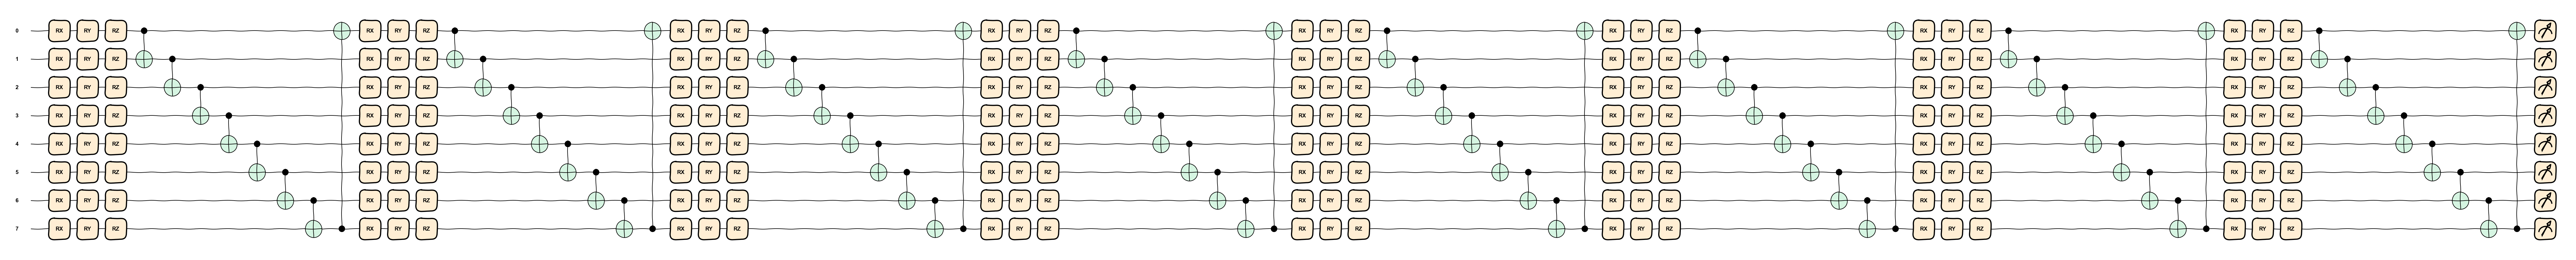

Trainable parameters: 192


In [76]:
num_qubits = 8
num_layers = 8
model = FullQuantumModel(qubits=num_qubits, layers=num_layers, num_classes=6)
model.draw(style = 'sketch')
model.trainable_parameters()

In [30]:
model.trainable_layers()

{'layer_0': True, 'layer_1': True, 'layer_2': True, 'layer_3': True, 'layer_4': True, 'layer_5': True, 'layer_6': True, 'layer_7': True}


The number of trainable parameters are 24 per layer, 1 parameter per rotation, 3 rotations per qubit, 8 qubits in total.

# Mid circuit measurements model

For simplicity, suppose we want to perform classification on 4 classes. 

We can associate label 0,1,2,3 to states $|00 \rangle, |01 \rangle, |10 \rangle, |11 \rangle$. The idea for early exits is to measure the first pair of qubits for the first exits, the second pair of qubits for the second, the third pair of qubits for the third and the last pair of qubits for the last one. Maybe we could also reduce the number of exits to 2 or 3 instead of 4, we'll see. Given that a measurement affect the state of the system, we need to explore a bit the theory behind mid circuit measurements.

# Mid circuit measurements
A [measurement](https://pennylane.ai/qml/demos/tutorial_mcm_introduction/) $M$ is a process that maps a valid quantum state $\rho$ (density operator) to a classical probabilistic mixture of post measurement quantum states $\rho_i$, specified by $M$: 

$$
M[\rho] = \sum \limits_{i=1}^n p_i \rho_i
$$

where $n$ is the number of possible outcomes and $p_i$ the probability to measure outcome $i$ associated to $\rho_i$. This describes the probabilistic mixture after the measurement if we do not record the outcome. If the outcome is recorded, we no longer have a probabilistic mixture but the state $\rho_i$ associated to the filtered outcome $i$. 

Considering the so called projective measurements, calling $\Pi_i$ the projector associated to the measurement outcome, with all projectors summming to the identity, the post measurement states are given by: 

$$
\rho_i = \frac{\Pi_i \rho \Pi_i}{\text{tr}[\Pi_i \rho]}
$$

where $p_i = \text{tr}[\Pi_i \rho]$. If we do not measure the outcome the system will end up in state: 

$$
M[\rho] = \sum \limits_{i=1}^n \Pi_i \rho \Pi_i
$$

## Theory addendum: Generalized Quantum Measurements

Generalized measurements are a collection of operators $\{ M_i\}$ such that for pure states the probability of the measurement outcome $i$ is given by:

$$
p(i) = \langle \psi | M_i^{\dagger} M_i | \psi \rangle
$$

The state of the system after the measurement, given that the outcome $i$ was obtained, is:

$$
|\psi'\rangle = \frac{M_i |\psi\rangle}{\sqrt{\langle \psi | M_i^{\dagger} M_i | \psi \rangle}}
$$

For mixed states instead the probability of the measurement outcome $i$ is given by: 
$$
p(i) = \text{tr}[\rho M_i^{\dagger} M_i]
$$

The state of the system after the measurement, given that the outcome $i$ was obtained, is:

$$
\rho' = \frac{M_i^{\dagger} \rho M_i}{\text{tr}[\rho M_i^{\dagger} M_i]}
$$

From that, we can define the so called **Positive Operator Valued Measurements (POVM)** as $\Pi_i=M_i^\dagger M_i$ where $\sum \limits_i \Pi_i = \mathbf{I}$. They are non negative and for pure states the probability of obtaining outcome $i$ is $p(i)= \langle \psi |\Pi_i |\psi \rangle$, while for mixed state is $p(i) = \text{tr}[\rho \Pi_i]$. 

The **projective measurements** are a specific class of Generalized Measurements  where $P_i = | i \rangle  \langle i |$, $\sum_i P_i = \mathbf{I}$, $P_iP_j = \delta_{ij} P_i$ and $P_i^2 = \mathbf{I}$. In this case for pure states the probability of obtaining outcome $i$ is: 

$$
p(i) = \langle \psi |P_i| \psi \rangle
$$

and the final state is: 

$$
|\psi' \rangle = \frac{P_i |\psi \rangle}{ \sqrt{\langle \psi |P_i| \psi \rangle}}
$$

For mixed state the probability to obtain an outcome $i$ is given by: 

$$
p(i) = \text{tr}[\rho P_i]
$$

And the final state: 

$$
\rho' = \frac{P_i \rho P_i}{\text{tr}[\rho P_i]}
$$

In PennyLane, the measurements with unknown outcomes are [Measurement Value](https://docs.pennylane.ai/en/stable/code/api/pennylane.measurements.MeasurementValue.html) objects. 

## Mid-circuit-Measurements model

In our model we would like to register the outcome of each mid circuit measurements of two qubits to be used for classification of the input image in each early exits, then the resulting state will not be in a probabilistic mixture but will be the one $\rho_i$ associated to the outcome $i$. 

How can we measure the confidence associated to classification at each step?

### First approach: 

Access to the probabilities associated to the measured state and use the highest probability between the 4 as confidence measure of the correspondent predicted label for the input image. In simulation, the circuit is run a number of *shots* specified in the [`device`](https://docs.pennylane.ai/en/stable/code/api/pennylane.device.html) definition. In general, supposing to take measurements using [`qml.sample()`](https://docs.pennylane.ai/en/stable/code/api/pennylane.sample.html), it will return as many samples as specified in the shots argument. With an high enough number of samples, the result can be used to estimate the probability to obtain a specific outcome for that. In practice it will be more useful to use directly [`qml.probs()`](https://docs.pennylane.ai/en/stable/code/api/pennylane.probs.html) with `op` argument the sequence of `MeasurementValue` objects coming from mid circuit measurements. 

(In inference would we need a single shot classification or we can assume that we can repeat for a given number of times the computation? I think that the assumption is always that the circuit is run multiple times, otherwise it would be impossible to estimate a quantum state with one shot. In fact to access to a state in one shot through PennyLane I think that can be considered 'cheating'.)

### Second approach:

The second approach is to use the [fidelity](https://en.wikipedia.org/wiki/Fidelity_of_quantum_states) to quantify the confidence associated to a given output. 

**Theory: Fidelity Measure**

The fidelity (square root fidelity) is a 'distance' measure between quantum states that for arbitrary states (defined through density operators) is defined as: 

$$
F(\rho, \sigma) = \text{tr}^2[ \sqrt{\rho^{\frac{1}{2}} \sigma \rho^{\frac{1}{2}}}]
$$

If $\rho$ and $\sigma$ commute, i.e. when they are diagonal in the same basis: $\rho = \sum \limits_i r_i |i\rangle \langle i|$ and $\sigma = \sum \limits_i s_i |i\rangle \langle i|$ for some orthonormal basis, the fidelity reduces to: 

$$
F(\rho, \sigma) = \sum \limits_i r_i s_i
$$


The fidelity between a pure state $|\psi \rangle$ and an arbitrary state $\rho$ is given by: 

$$
F(\rho, |\psi\rangle) = \langle \psi|\rho |\psi \rangle
$$

That is the square root of the overlap between them. 

Finally, the fidelity between two pure states $|\phi\rangle, |\psi\rangle$: 

$$
F(|\phi\rangle, |\psi\rangle) = |\langle \phi|\psi\rangle|^2
$$

For example, $F(\frac{|0\rangle \langle 0| + |1\rangle \langle 1|}{2}, |0\rangle) = \frac{1}{2}$, $F(|0\rangle,|0\rangle) = 1$, $F(|0\rangle,|1\rangle) = 0$, $F(|+\rangle,|0\rangle) = \frac{1}{2}$.

In general the value of the fidelity is comprised between 0 and 1 (the higher the similar). 


### Fidelity measurements for classical estimation

From the course in Quantum Information I learned that fidelity can be used to assess the quality of a **classical estimation** of a quantum state. Suppose Alice want to communicate a pure state to Bob $|\psi \rangle = \alpha |0\rangle + \beta |1 \rangle$ <u>without</u> a quantum channel. Imagine that you have infinite copies of the quantum state, Alice can measure his state in the computational basis and communicate the outcomes classically to Bob. Bob can then can characterize the quantum system (with some limitations) proposing a $\hat{\rho}_G$ guess whose quality will depend on the quantity of transferred information and can be measured using the fidelity.

In general, we can not directly access to a quantum state. What we can do is to run the circuit many times obtaining a number of outputs given by the number of `shots` specified in the device initialization. Using [`qml.probs()`](https://docs.pennylane.ai/en/stable/code/api/pennylane.probs.html) with a given number of shots, we are extracting our guess from the sampling process, whose "closeness" to the four vectors of the computational basis can be evaluated using fidelity.

In order to perform a Mid Circuit Measurement PennyLane suggests to use [`qml.measure()`](https://docs.pennylane.ai/en/stable/code/api/pennylane.measure.html)

### Application:

Having 4 classes, they can be associated to states $|00\rangle, |01\rangle, |10\rangle,|11\rangle$. Our aim is to have as output a state that have the higher possible fidelity, i.e. we want the state before the measurement to be as close as possible to one of the fourth basis vectors. Then the fidelity could be used as a confidence measure in the classification at each early exits setting a threshold: 

1. Measure the first 2 qubits -> classification, if the fidelity is high enough we can stop here, otherwise continue; 
2. Measure the second pair of qubits -> classification, if the fidelity is high enough we can stop here, otherwise continue; 
3. Repeat for how many early exits have you put, if the fidelity is never adequately high take the output of all the layers.

## Pennylane measurement

According to [Pennylane](https://pennylane.ai/blog/2022/06/how-to-do-measurements-in-pennylane/), in real experiment the actual wave function is not accessible but we can "cheat" taking as output a set of measurement from the resulting state. There exists some function in Pennylane in order to do that: 

- [`qml.sample()`](https://docs.pennylane.ai/en/stable/code/api/pennylane.sample.html) is used to output a number of samples specified in the *device* definition (shots param) of the indicated observable, such as `qml.sample(qml.PauliY(0))`. Basically, Pennylane is sampling the eigenvalues $\lambda_i$ with their associated probabilites $p(\lambda_i)=|\langle \xi_i |\psi\rangle|^2$, where $|\xi_i\rangle$ is the corresponding basis state in the basis of observables. In the case we want to measure one of the four possible basis in our example the basis will be the computational one with 0,1 eigenvalues. Since it is a stochastich process it is **not differentiable**. 
- [`qml.probs()`](https://docs.pennylane.ai/en/stable/code/api/pennylane.probs.html) return an array in lexiographic order containing the probabilities $|\langle i | \psi \rangle|^2$ of measuring the computational basis state $|i\rangle$ in the current state $|\psi \rangle$ if no observable are specified. Specifying the number of `shots` in the device definition the function will output <u> the probabilities given by the sampling process</u>. Then, with an high enough number of samples we can assume we are able to reconstruct the quantum state. 

Following the example provided in [this PennyLane tutorial](https://pennylane.ai/qml/demos/tutorial_how_to_collect_mcm_stats/) that is hereafter reported, we can try to adapt the reasoning to our model...

Probability vector of first qubit MCM: [0.8 0.2]
Bit string counts on other qubits: {'000': 71, '011': 8, '100': 9, '111': 12}


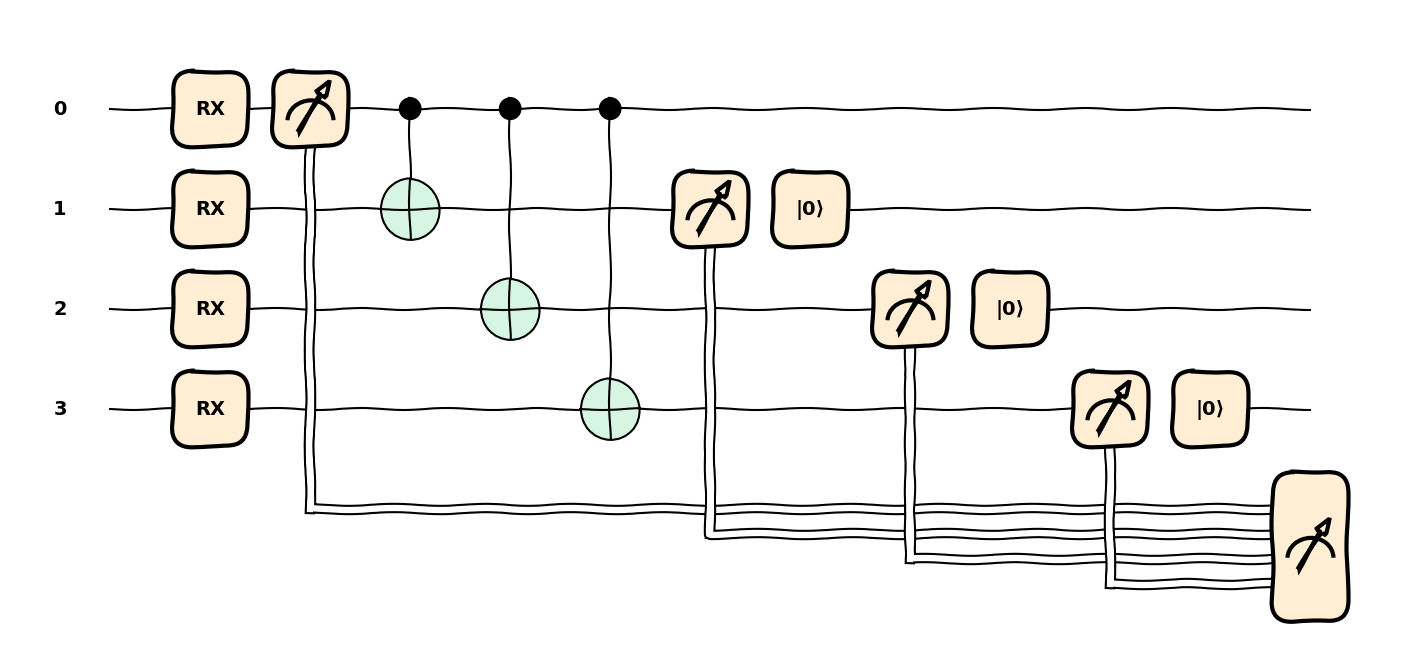

In [4]:
"""Pennylane example """

np.random.seed(511)

first_wire = 0
other_wires = [1, 2, 3]

def ansatz(x):
    mcms = []

    # Rotate all qubits
    for w, x_ in enumerate(x):
        qml.RX(x_, w)

    # Measure first qubit
    mcms.append(qml.measure(first_wire))

    # Entangle all qubits with first qubit
    for w in other_wires:
        qml.CNOT([first_wire, w])

    # Measure and reset all qubits but the first
    for w in other_wires:
        mcms.append(qml.measure(w, reset=True))

    return mcms

dev = qml.device("default.qubit", shots=100)
@qml.qnode(dev)
def simple_node(x):
    # apply the ansatz, and collect mid-circuit measurements. mcm1 is the measurement
    # of wire 0, and mcms2 is a list of measurements of the other wires.
    mcm1, *mcms2 = ansatz(x)
    return qml.probs(op=mcm1), qml.counts(mcms2)

x = np.random.random(4)
fig, ax = qml.draw_mpl(simple_node)(x)
probs, counts = qml.defer_measurements(simple_node)(x)
print(f"Probability vector of first qubit MCM: {np.round(probs, 5)}")
print(f"Bit string counts on other qubits: {counts}")

[**Defer Measurements**](https://docs.pennylane.ai/en/stable/code/api/pennylane.defer_measurements.html) are used to speed up the circuit execution. According to Nielsen Chuang, measurement can always be moved from an intermediate stage of a quantum circuit to the end of the circuit; if the measurement results are used at any stage og the circuit then classically controlled operations can be replaced by conditional quantum operation. 

# Ansatz of the model 

Let's consider 4 classes for the original model without early exits... 


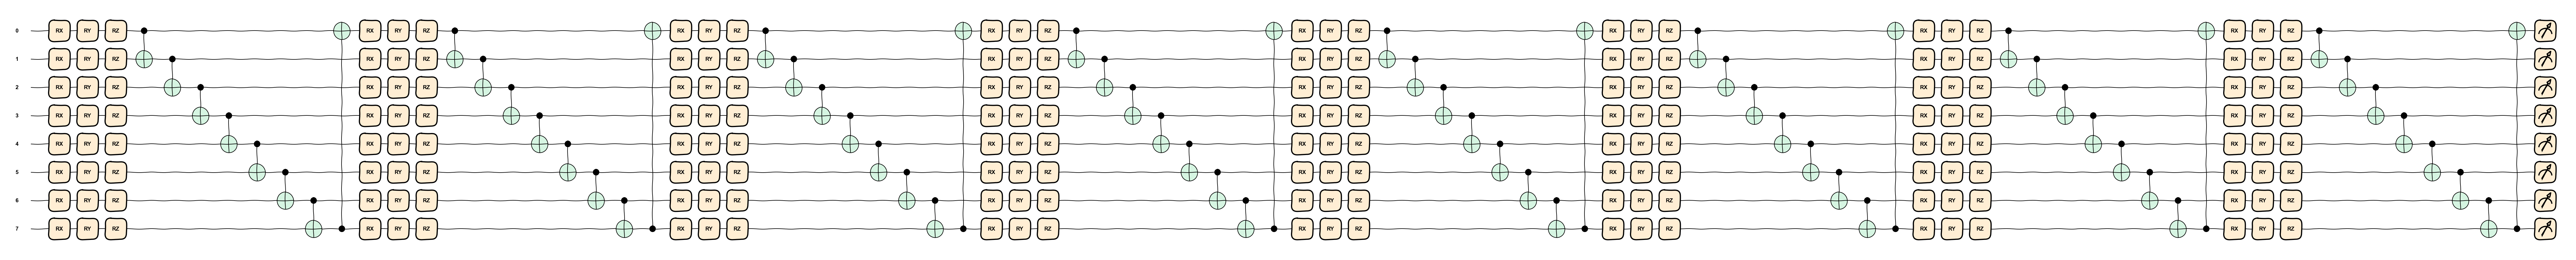

In [15]:
model.draw(style = 'sketch')

In [81]:
#dataset preparation

labels = [0,1,2,3]
# Download MNIST and prepare transforms
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
                                transforms.Resize((16, 16)),  # Resize to 16x16
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))  # Normalize
                             ]))
#train/test 80/20 split, see data_utils.py for further details
train_dataloader, test_dataloader = mnist_preparation(dataset=mnist, labels = labels, train_test_ratio=0.8,batch_size=64)

print("Images in the training set: ", len(train_dataloader.dataset), "\n Images in the test set: ", len(test_dataloader.dataset))

Images in the training set:  19803 
 Images in the test set:  4951


In [51]:
#check all layers are set as trainable
model.trainable_layers()

{'layer_0': True, 'layer_1': True, 'layer_2': True, 'layer_3': True, 'layer_4': True, 'layer_5': True, 'layer_6': True, 'layer_7': True}


In [52]:
#We could freeze a layer if we want with the following method of the class in OriginalModel.py
model.freeze_layers([0,1])
model.trainable_layers()
model.trainable_parameters()

{'layer_0': False, 'layer_1': False, 'layer_2': True, 'layer_3': True, 'layer_4': True, 'layer_5': True, 'layer_6': True, 'layer_7': True}
Trainable parameters: 144


In [53]:
# We can also unfreeze them
model.unfreeze_layers([0,1])
model.trainable_layers()
model.trainable_parameters()

{'layer_0': True, 'layer_1': True, 'layer_2': True, 'layer_3': True, 'layer_4': True, 'layer_5': True, 'layer_6': True, 'layer_7': True}
Trainable parameters: 192


## Training of the original model

Epoch 1/15: 100%|██████████| 450/450 [00:25<00:00, 17.59it/s, accuracy=0.672, loss=1.71]


Time per epoch:  25.59093713760376
Epoch:  1 Loss:  1.738808002471924
Accuracy:  0.6324305555555556
--------------------------------------------------------------------------


Epoch 2/15: 100%|██████████| 450/450 [00:25<00:00, 17.38it/s, accuracy=0.688, loss=1.71]


Time per epoch:  25.892921924591064
Epoch:  2 Loss:  1.7091605422231886
Accuracy:  0.6982986111111111
--------------------------------------------------------------------------


Epoch 3/15: 100%|██████████| 450/450 [00:26<00:00, 17.16it/s, accuracy=0.719, loss=1.69]


Time per epoch:  26.22997212409973
Epoch:  3 Loss:  1.6995827526516385
Accuracy:  0.6918402777777778
--------------------------------------------------------------------------


Epoch 4/15: 100%|██████████| 450/450 [00:26<00:00, 16.95it/s, accuracy=0.656, loss=1.7] 


Time per epoch:  26.55077028274536
Epoch:  4 Loss:  1.6942655868000454
Accuracy:  0.6878472222222223
--------------------------------------------------------------------------


Epoch 5/15: 100%|██████████| 450/450 [00:26<00:00, 17.13it/s, accuracy=0.766, loss=1.68]


Time per epoch:  26.27556800842285
Epoch:  5 Loss:  1.6911555851830375
Accuracy:  0.6972222222222222
--------------------------------------------------------------------------


Epoch 6/15: 100%|██████████| 450/450 [00:26<00:00, 16.90it/s, accuracy=0.578, loss=1.69]


Time per epoch:  26.621307849884033
Epoch:  6 Loss:  1.6893894995583427
Accuracy:  0.6994097222222222
--------------------------------------------------------------------------


Epoch 7/15: 100%|██████████| 450/450 [00:26<00:00, 17.00it/s, accuracy=0.625, loss=1.68]


Time per epoch:  26.477379083633423
Epoch:  7 Loss:  1.6880911458863153
Accuracy:  0.6979861111111111
--------------------------------------------------------------------------


Epoch 8/15: 100%|██████████| 450/450 [00:26<00:00, 17.16it/s, accuracy=0.75, loss=1.69] 


Time per epoch:  26.225884199142456
Epoch:  8 Loss:  1.6872670584254794
Accuracy:  0.6959375
--------------------------------------------------------------------------


Epoch 9/15: 100%|██████████| 450/450 [00:26<00:00, 17.03it/s, accuracy=0.688, loss=1.69]


Time per epoch:  26.430726051330566
Epoch:  9 Loss:  1.6868873540560405
Accuracy:  0.6935069444444445
--------------------------------------------------------------------------


Epoch 10/15: 100%|██████████| 450/450 [00:26<00:00, 17.02it/s, accuracy=0.734, loss=1.68]


Time per epoch:  26.43678331375122
Epoch:  10 Loss:  1.6866859753926595
Accuracy:  0.6948958333333334
--------------------------------------------------------------------------


Epoch 11/15: 100%|██████████| 450/450 [00:26<00:00, 16.97it/s, accuracy=0.719, loss=1.68]


Time per epoch:  26.511101961135864
Epoch:  11 Loss:  1.6865301055378383
Accuracy:  0.6948611111111112
--------------------------------------------------------------------------


Epoch 12/15: 100%|██████████| 450/450 [00:26<00:00, 16.94it/s, accuracy=0.625, loss=1.71]


Time per epoch:  26.559650182724
Epoch:  12 Loss:  1.6864140542348225
Accuracy:  0.6954861111111111
--------------------------------------------------------------------------


Epoch 13/15: 100%|██████████| 450/450 [00:26<00:00, 17.01it/s, accuracy=0.797, loss=1.66]


Time per epoch:  26.452311038970947
Epoch:  13 Loss:  1.6863111058870952
Accuracy:  0.6970486111111112
--------------------------------------------------------------------------


Epoch 14/15: 100%|██████████| 450/450 [00:26<00:00, 16.93it/s, accuracy=0.734, loss=1.67]


Time per epoch:  26.587449073791504
Epoch:  14 Loss:  1.6861878956688774
Accuracy:  0.6978472222222222
--------------------------------------------------------------------------


Epoch 15/15: 100%|██████████| 450/450 [00:26<00:00, 16.95it/s, accuracy=0.5, loss=1.72]  


Time per epoch:  26.549011945724487
Epoch:  15 Loss:  1.6859683251380921
Accuracy:  0.6977777777777778
--------------------------------------------------------------------------


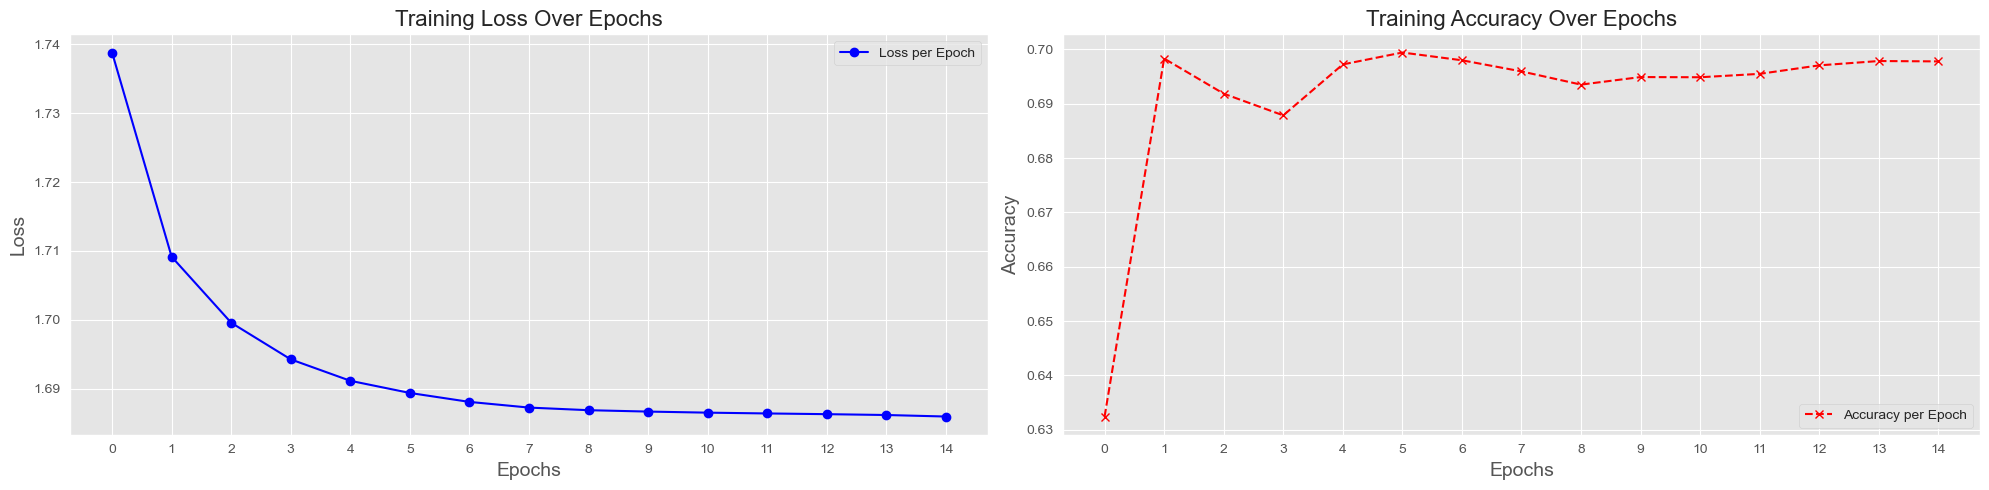

In [78]:
"""Let's proceed with training using the fit method defined in the class in OriginalModel.py
    In this case, I will use the standard training loop over the whole model."""
accuracy, loss = model.fit(dataloader=train_dataloader, learning_rate=0.001, epochs=15, show_plot=True)

## Test of the original model

In [79]:
model.freeze_layers([0,1,2,3,4,5,6,7])
model.trainable_parameters()

#simplified per image test set evaluation
result = []
for img, label in tqdm(test_dataloader.dataset):
    img = img / torch.linalg.norm(img).view(-1, 1) #image normalization
    probs = model.forward(state=img) #extract probabilities
    prediction = torch.argmax(probs, dim=1) 
    result.append((prediction, label))

Trainable parameters: 0


100%|██████████| 7204/7204 [02:01<00:00, 59.09it/s]


In [80]:
def calculate_accuracy(data):
    correct = sum([1 for label, prediction in data if label == prediction])
    return correct, correct / len(data)

test_results = calculate_accuracy(result)

print(test_results[0], "elements have been correctly classified over", len(test_dataloader.dataset), "total images with an accuracy of ", test_results[1])

4973 elements have been correctly classified over 7204 total images with an accuracy of  0.6903109383675736


# Mid circuit measurements ansatz

Let's start with only one mid circuit measurement in the middle of the circuit after 4 layers...

The first pair of qubits will be used for the mid circuit measurement and the second pair for the final classification...  

In [5]:
num_qubits = 8
num_layers = 8
params = torch.nn.ParameterDict({
            f'layer_{i}': torch.nn.Parameter(torch.rand(num_qubits, 3, requires_grad=True))
            for i in range(num_layers)
        })

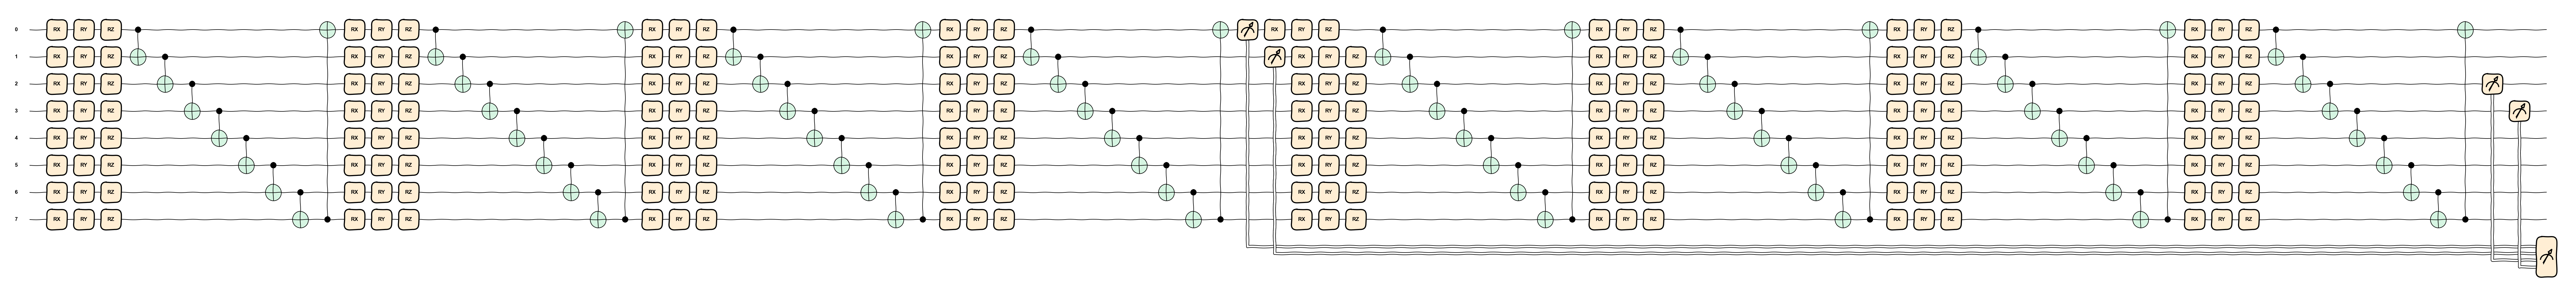

In [6]:
first_pair = [0,1]
second_pair = [2,3]

def ansatz_1(parameters: Dict, state: torch.Tensor = None): 
    mcms =  []
    if state is not None: 
        # state vector initialization with input
        qml.QubitStateVector(state, wires=range(num_qubits))
        
    for i in range(4): 
        for j in range(num_qubits): 
            qml.RX(parameters[f'layer_{i}'][j, 0], wires=j)
            qml.RY(parameters[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(parameters[f'layer_{i}'][j, 2], wires=j)
        for j in range(num_qubits):
            qml.CNOT(wires=[j, (j + 1) % num_qubits])   
    for w in first_pair: 
        mcms.append(qml.measure(wires=w))
    
    for i in range(4, num_layers): 
        for j in range(num_qubits): 
            qml.RX(parameters[f'layer_{i}'][j, 0], wires=j)
            qml.RY(parameters[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(parameters[f'layer_{i}'][j, 2], wires=j)
        for j in range(num_qubits):
            qml.CNOT(wires=[j, (j + 1) % num_qubits])
   
    for w in second_pair: 
        mcms.append(qml.measure(wires=w))
    return mcms

dev = qml.device("default.qubit", shots=10)
@qml.qnode(dev)
def circuit_1(parameters: Dict, state: torch.Tensor = None): 
    results = ansatz_1(parameters, state)
    mcm = results[0:2]
    fm = results[2:]
    return qml.probs(op=mcm), qml.probs(op=fm)

fig, ax = qml.draw_mpl(circuit_1)(params)
fig.savefig('/Users/jackvittori/Desktop/QML-early_exit/mcm-circuit-measurements.png')

In [15]:
for data, target in train_dataloader: 
    data = data / torch.linalg.norm(data, dim=1).view(-1, 1)
    a = circuit_1(parameters=params, state = data)    
    break

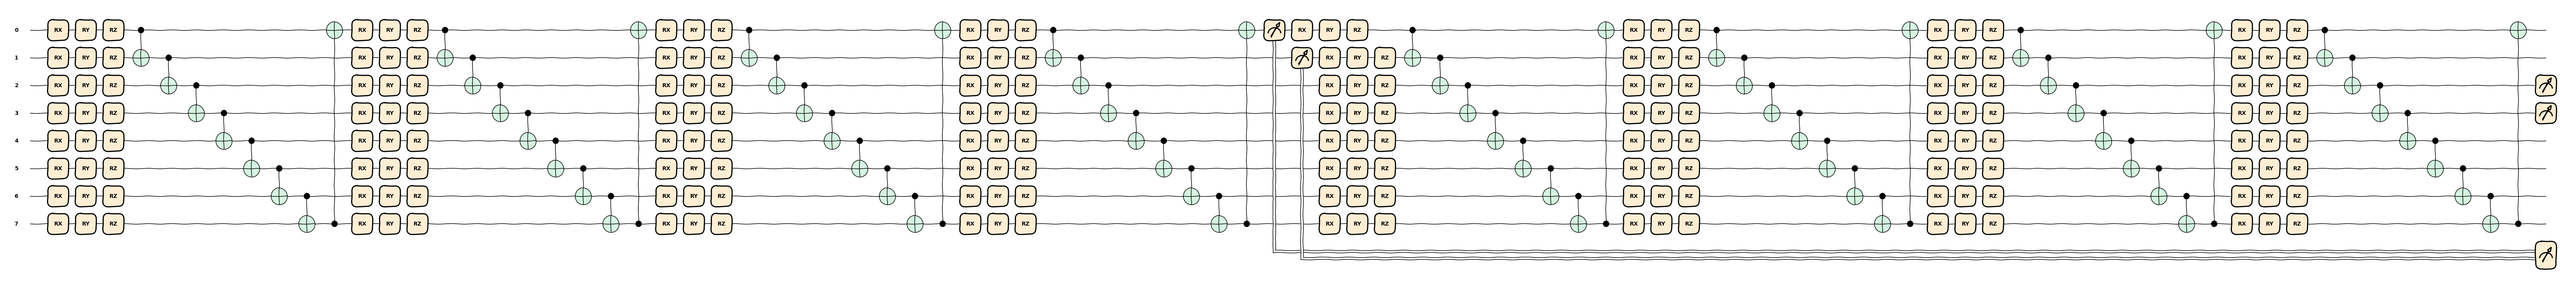

In [16]:
first_pair = [0,1]
second_pair = [2,3]

def ansatz_2(parameters: Dict, state: torch.Tensor = None): 
    
    if state is not None: 
        # state vector initialization with input
        qml.QubitStateVector(state, wires=range(num_qubits))
        
    for i in range(4): 
        for j in range(num_qubits): 
            qml.RX(parameters[f'layer_{i}'][j, 0], wires=j)
            qml.RY(parameters[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(parameters[f'layer_{i}'][j, 2], wires=j)
        for j in range(num_qubits):
            qml.CNOT(wires=[j, (j + 1) % num_qubits])
            
    mcm = [qml.measure(wire) for wire in first_pair]
    
    for i in range(4, num_layers): 
        for j in range(num_qubits): 
            qml.RX(parameters[f'layer_{i}'][j, 0], wires=j)
            qml.RY(parameters[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(parameters[f'layer_{i}'][j, 2], wires=j)
        for j in range(num_qubits):
            qml.CNOT(wires=[j, (j + 1) % num_qubits])
    return mcm

dev = qml.device("default.qubit", shots=10)
@qml.qnode(dev, interface = 'torch')
def circuit_2(parameters: Dict, state: torch.Tensor = None):
    mcm = ansatz_2(parameters, state)
    return qml.probs(op=mcm), qml.probs(wires=second_pair)

fig, ax = qml.draw_mpl(circuit_2)(params)
fig.savefig('test.png')

In [17]:
for data, target in train_dataloader: 
    data = data / torch.linalg.norm(data, dim=1).view(-1, 1)
    a = circuit_2(parameters=params, state = data)    
    break

Specifying the number of shots is not working defining the model because Pennylane is estimating qml.probs() using qml.sample() under the hoods and qml.sample() is not differentiable. 

# MCMQuantum model

See [mcmModel.py](https://github.com/JackVittori/QML-early_exit/blob/530cedde3ea00d82bcc46479ef4d242e83be8f0a/mcmModel.py) for further details. 

In [2]:
model = MCMQuantumModel(qubits = 8, layers = 8, ansatz = 'ansatz_1')

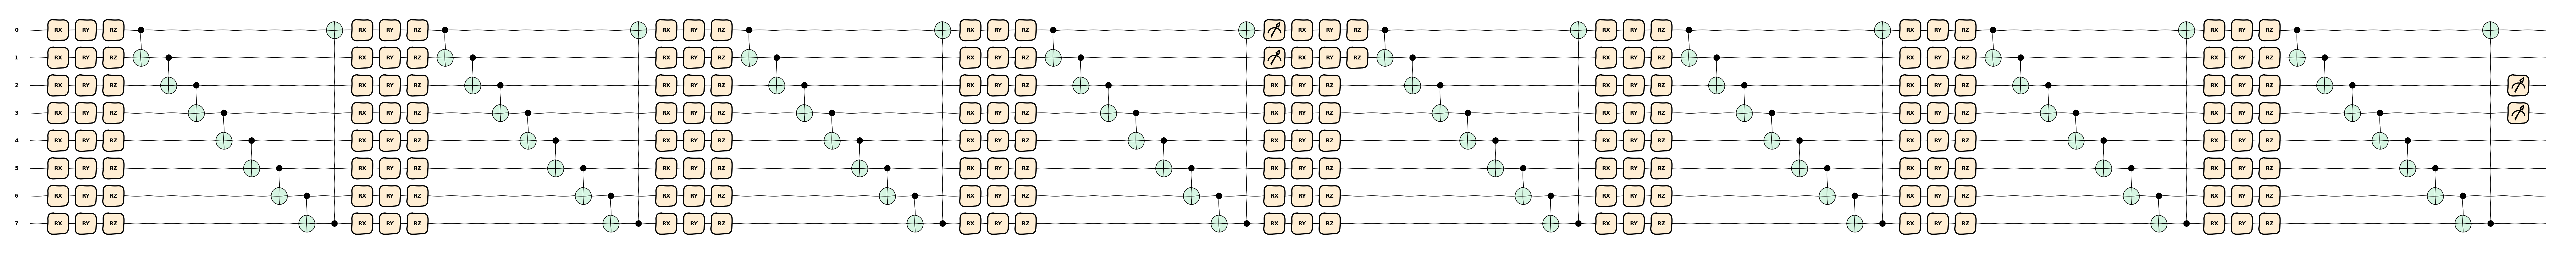

In [3]:
model.draw(style='sketch')

In [4]:
model.trainable_layers()

{'layer_0': True, 'layer_1': True, 'layer_2': True, 'layer_3': True, 'layer_4': True, 'layer_5': True, 'layer_6': True, 'layer_7': True}


In [5]:
model.freeze_layers([0,1])

In [6]:
model.trainable_layers()

{'layer_0': False, 'layer_1': False, 'layer_2': True, 'layer_3': True, 'layer_4': True, 'layer_5': True, 'layer_6': True, 'layer_7': True}


In [7]:
model.unfreeze_layers([0,1])
model.trainable_layers()

{'layer_0': True, 'layer_1': True, 'layer_2': True, 'layer_3': True, 'layer_4': True, 'layer_5': True, 'layer_6': True, 'layer_7': True}


## Model training
First of all let's split the dataset in train, validation and test reserving 70% of the dataset to the train set and splitting by 50% the remaining images.  

In [9]:
labels = [0,1,2,3]
# Download MNIST and prepare transforms
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
                                transforms.Resize((16, 16)),  # Resize to 16x16
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))  # Normalize
                             ]))
#train/test 80/20 split, see data_utils.py for further details
train_dataloader, validation_dataloader, test_dataloader = mnist_preparation(dataset=mnist, labels = labels, train_test_ratio=0.7,batch_size=64, vali_test_ratio=0.5)

print("Images in the training set: ", len(train_dataloader.dataset), "\n Images in the validation set: ", len(validation_dataloader.dataset), "\n Images in the test set: ", len(test_dataloader.dataset))

Images in the training set:  17327 
 Images in the validation set:  3713 
 Images in the test set:  3714


Epoch 1/20: 100%|██████████| 270/270 [01:39<00:00,  2.71it/s, fm_accuracy=0.812, loss=2.49, mcm_accuracy=0.703]


Time per epoch (s):  99.52638006210327
Epoch:  1 Loss:  2.6098268040904293
--------------------------------------------------------------------------
Mid circuit accuracy:  0.5599537037037037
--------------------------------------------------------------------------
Final Measurement accuracy:  0.6340277777777777
--------------------------------------------------------------------------


Epoch 2/20: 100%|██████████| 270/270 [01:42<00:00,  2.63it/s, fm_accuracy=0.797, loss=2.33, mcm_accuracy=0.875]


Time per epoch (s):  102.49435019493103
Epoch:  2 Loss:  2.407637033639131
--------------------------------------------------------------------------
Mid circuit accuracy:  0.7958912037037037
--------------------------------------------------------------------------
Final Measurement accuracy:  0.7854166666666667
--------------------------------------------------------------------------


Epoch 3/20: 100%|██████████| 270/270 [01:42<00:00,  2.63it/s, fm_accuracy=0.812, loss=2.28, mcm_accuracy=0.859]


Time per epoch (s):  102.83928394317627
Epoch:  3 Loss:  2.3064192789572258
--------------------------------------------------------------------------
Mid circuit accuracy:  0.8479745370370371
--------------------------------------------------------------------------
Final Measurement accuracy:  0.8091435185185185
--------------------------------------------------------------------------


Epoch 4/20: 100%|██████████| 270/270 [01:42<00:00,  2.63it/s, fm_accuracy=0.891, loss=2.2, mcm_accuracy=0.844] 


Time per epoch (s):  102.50470089912415
Epoch:  4 Loss:  2.2416205238412927
--------------------------------------------------------------------------
Mid circuit accuracy:  0.8491898148148148
--------------------------------------------------------------------------
Final Measurement accuracy:  0.8429976851851851
--------------------------------------------------------------------------


Epoch 5/20: 100%|██████████| 270/270 [01:38<00:00,  2.76it/s, fm_accuracy=0.875, loss=2.14, mcm_accuracy=0.922]


Time per epoch (s):  98.00180983543396
Epoch:  5 Loss:  2.21178041210881
--------------------------------------------------------------------------
Mid circuit accuracy:  0.842650462962963
--------------------------------------------------------------------------
Final Measurement accuracy:  0.8828703703703704
--------------------------------------------------------------------------


Epoch 6/20: 100%|██████████| 270/270 [01:39<00:00,  2.73it/s, fm_accuracy=0.938, loss=2.12, mcm_accuracy=0.906]


Time per epoch (s):  99.03256392478943
Epoch:  6 Loss:  2.176102069572166
--------------------------------------------------------------------------
Mid circuit accuracy:  0.8502314814814815
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9054976851851851
--------------------------------------------------------------------------


Epoch 7/20: 100%|██████████| 270/270 [01:38<00:00,  2.74it/s, fm_accuracy=0.859, loss=2.15, mcm_accuracy=0.891]


Time per epoch (s):  98.43760299682617
Epoch:  7 Loss:  2.138952234056261
--------------------------------------------------------------------------
Mid circuit accuracy:  0.860011574074074
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9152777777777777
--------------------------------------------------------------------------


Epoch 8/20: 100%|██████████| 270/270 [01:38<00:00,  2.74it/s, fm_accuracy=0.906, loss=2.12, mcm_accuracy=0.797]


Time per epoch (s):  98.56715202331543
Epoch:  8 Loss:  2.1187363827670063
--------------------------------------------------------------------------
Mid circuit accuracy:  0.8556134259259259
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9175347222222222
--------------------------------------------------------------------------


Epoch 9/20: 100%|██████████| 270/270 [01:39<00:00,  2.72it/s, fm_accuracy=0.891, loss=2.08, mcm_accuracy=0.859]


Time per epoch (s):  99.3086347579956
Epoch:  9 Loss:  2.107430307953446
--------------------------------------------------------------------------
Mid circuit accuracy:  0.8571180555555555
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9149884259259259
--------------------------------------------------------------------------


Epoch 10/20: 100%|██████████| 270/270 [01:42<00:00,  2.62it/s, fm_accuracy=0.953, loss=2, mcm_accuracy=0.859]   


Time per epoch (s):  102.93088889122009
Epoch:  10 Loss:  2.1000517858399284
--------------------------------------------------------------------------
Mid circuit accuracy:  0.8594328703703704
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9140625
--------------------------------------------------------------------------


Epoch 11/20: 100%|██████████| 270/270 [01:42<00:00,  2.65it/s, fm_accuracy=0.938, loss=2.1, mcm_accuracy=0.828] 


Time per epoch (s):  102.02802300453186
Epoch:  11 Loss:  2.0927487126103155
--------------------------------------------------------------------------
Mid circuit accuracy:  0.858738425925926
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9107060185185185
--------------------------------------------------------------------------


Epoch 12/20: 100%|██████████| 270/270 [01:46<00:00,  2.54it/s, fm_accuracy=0.922, loss=2.03, mcm_accuracy=0.859]


Time per epoch (s):  106.36453819274902
Epoch:  12 Loss:  2.0827427316595006
--------------------------------------------------------------------------
Mid circuit accuracy:  0.8586805555555556
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9124421296296297
--------------------------------------------------------------------------


Epoch 13/20: 100%|██████████| 270/270 [01:49<00:00,  2.46it/s, fm_accuracy=0.906, loss=2.13, mcm_accuracy=0.766]


Time per epoch (s):  109.81930589675903
Epoch:  13 Loss:  2.0726306438446045
--------------------------------------------------------------------------
Mid circuit accuracy:  0.8618634259259259
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9166666666666666
--------------------------------------------------------------------------


Epoch 14/20: 100%|██████████| 270/270 [01:45<00:00,  2.56it/s, fm_accuracy=0.938, loss=2.03, mcm_accuracy=0.859]


Time per epoch (s):  105.34568691253662
Epoch:  14 Loss:  2.064727486945965
--------------------------------------------------------------------------
Mid circuit accuracy:  0.8650462962962963
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9195023148148148
--------------------------------------------------------------------------


Epoch 15/20: 100%|██████████| 270/270 [01:41<00:00,  2.67it/s, fm_accuracy=0.953, loss=2.06, mcm_accuracy=0.875]


Time per epoch (s):  101.13181018829346
Epoch:  15 Loss:  2.0578980008761087
--------------------------------------------------------------------------
Mid circuit accuracy:  0.8655671296296297
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9190972222222222
--------------------------------------------------------------------------


Epoch 16/20: 100%|██████████| 270/270 [01:45<00:00,  2.57it/s, fm_accuracy=0.922, loss=2.07, mcm_accuracy=0.875]


Time per epoch (s):  105.07419395446777
Epoch:  16 Loss:  2.0512091393823977
--------------------------------------------------------------------------
Mid circuit accuracy:  0.8670717592592593
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9165509259259259
--------------------------------------------------------------------------


Epoch 17/20: 100%|██████████| 270/270 [01:48<00:00,  2.49it/s, fm_accuracy=0.922, loss=2.03, mcm_accuracy=0.891]


Time per epoch (s):  108.55247592926025
Epoch:  17 Loss:  2.0457161051255683
--------------------------------------------------------------------------
Mid circuit accuracy:  0.8664930555555556
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9109375
--------------------------------------------------------------------------


Epoch 18/20: 100%|██████████| 270/270 [01:46<00:00,  2.55it/s, fm_accuracy=0.891, loss=2.05, mcm_accuracy=0.938]


Time per epoch (s):  106.03313708305359
Epoch:  18 Loss:  2.041683863268958
--------------------------------------------------------------------------
Mid circuit accuracy:  0.8689236111111112
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9061342592592593
--------------------------------------------------------------------------


Epoch 19/20: 100%|██████████| 270/270 [01:47<00:00,  2.50it/s, fm_accuracy=0.828, loss=2.13, mcm_accuracy=0.828]


Time per epoch (s):  107.91952323913574
Epoch:  19 Loss:  2.038509410398978
--------------------------------------------------------------------------
Mid circuit accuracy:  0.8705439814814815
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9059606481481481
--------------------------------------------------------------------------


Epoch 20/20: 100%|██████████| 270/270 [01:50<00:00,  2.45it/s, fm_accuracy=0.922, loss=2.05, mcm_accuracy=0.844]


Time per epoch (s):  110.051522731781
Epoch:  20 Loss:  2.035941326176679
--------------------------------------------------------------------------
Mid circuit accuracy:  0.8684606481481482
--------------------------------------------------------------------------
Final Measurement accuracy:  0.9023726851851852
--------------------------------------------------------------------------


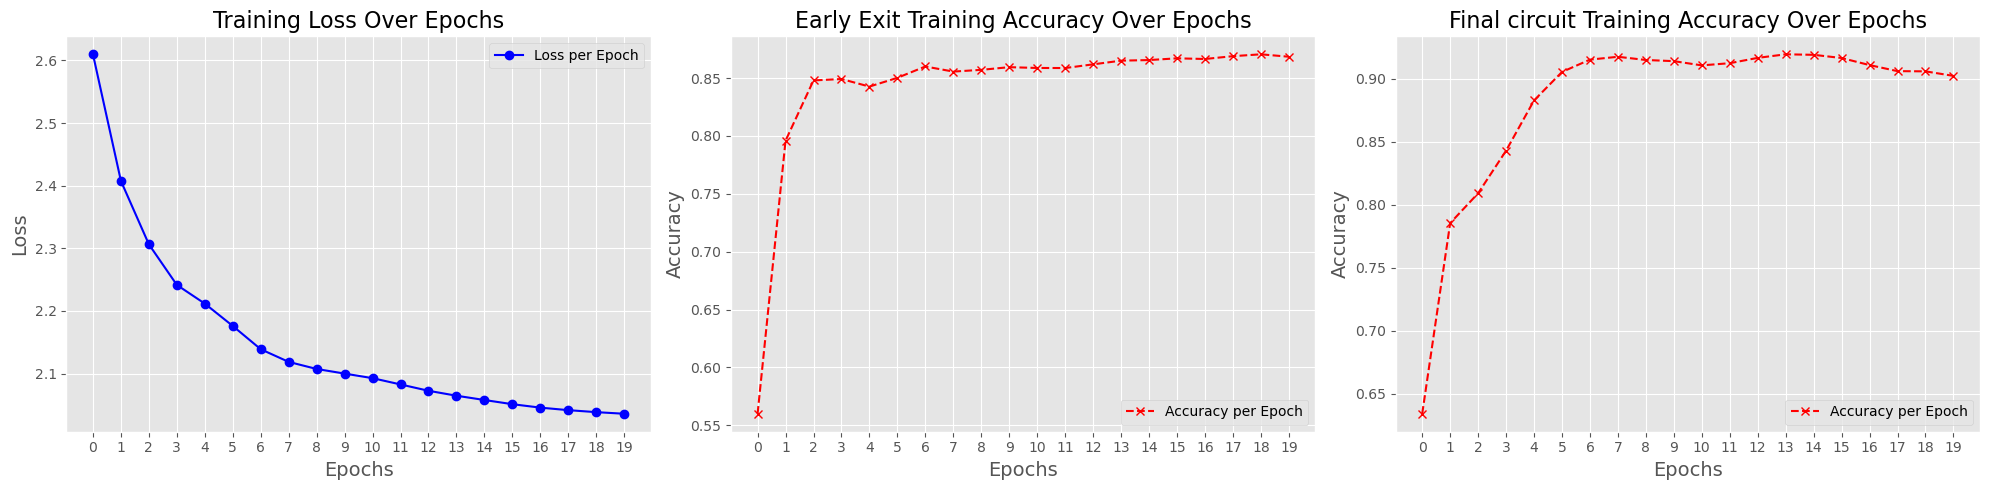

In [9]:
mcm_accuracy, fm_accuracy, loss_history = model.fit(dataloader = train_dataloader, learning_rate = 0.001, epochs = 20, show_plot = True)

## Model Evaluation
First of all we save the model parameters after the training

In [20]:
model_parameters = model.params

In [21]:
print(model_parameters)

ParameterDict(
    (layer_0): Parameter containing: [torch.FloatTensor of size 8x3]
    (layer_1): Parameter containing: [torch.FloatTensor of size 8x3]
    (layer_2): Parameter containing: [torch.FloatTensor of size 8x3]
    (layer_3): Parameter containing: [torch.FloatTensor of size 8x3]
    (layer_4): Parameter containing: [torch.FloatTensor of size 8x3]
    (layer_5): Parameter containing: [torch.FloatTensor of size 8x3]
    (layer_6): Parameter containing: [torch.FloatTensor of size 8x3]
    (layer_7): Parameter containing: [torch.FloatTensor of size 8x3]
)


In [22]:
import pickle

with open("/Users/jackvittori/Desktop/pesi.pickle", "wb") as file:
    pickle.dump(model_parameters, file)

In [5]:
# Rileggere la variabile
import pickle
with open("/Users/jackvittori/Desktop/pesi.pickle", "rb") as file:
    model_parameters = pickle.load(file) # Output: {'chiave': 'valore', 'numero': 123}


We want to run the circuit up to the early exit and if the probability is above a threshold we take the result, otherwise we want to run the circuit until the end taking the final prediction. In evaluation, we do not need differentiability, meaning that we can simulate the real case scenario where we run the circuit a given number of times. 

In [24]:
num_qubits = 8
num_layers = 8
params = model_parameters
np.random.seed(1234)
num_shots = 10
torch.manual_seed(1234)
first_pair = [0,1]
second_pair = [2,3]

def early_evaluation(parameters: Dict, state: torch.Tensor = None): 
    mcms =  []
    if state is not None: 
        # state vector initialization with input
        qml.QubitStateVector(state, wires=range(num_qubits))
        
    for i in range(4): 
        for j in range(num_qubits): 
            qml.RX(parameters[f'layer_{i}'][j, 0], wires=j)
            qml.RY(parameters[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(parameters[f'layer_{i}'][j, 2], wires=j)
        for j in range(num_qubits):
            qml.CNOT(wires=[j, (j + 1) % num_qubits])   
    for w in first_pair: 
        mcms.append(qml.measure(wires=w))
    return mcms

dev = qml.device("default.qubit", shots=num_shots)
#dev = qml.device("default.qubit")
@qml.qnode(dev)
def circuit_early_evaluation(parameters: Dict, state: torch.Tensor = None): 
    results = early_evaluation(parameters, state)
    return qml.probs(op=results)

def full_evaluation(parameters: Dict, state: torch.Tensor = None): 
    mcms =  []
    if state is not None: 
        # state vector initialization with input
        qml.QubitStateVector(state, wires=range(num_qubits))
        
    for i in range(4): 
        for j in range(num_qubits): 
            qml.RX(parameters[f'layer_{i}'][j, 0], wires=j)
            qml.RY(parameters[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(parameters[f'layer_{i}'][j, 2], wires=j)
        for j in range(num_qubits):
            qml.CNOT(wires=[j, (j + 1) % num_qubits])   
    for w in first_pair: 
        mcms.append(qml.measure(wires=w))
    
    for i in range(4, num_layers): 
        for j in range(num_qubits): 
            qml.RX(parameters[f'layer_{i}'][j, 0], wires=j)
            qml.RY(parameters[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(parameters[f'layer_{i}'][j, 2], wires=j)
        for j in range(num_qubits):
            qml.CNOT(wires=[j, (j + 1) % num_qubits])
   
    for w in second_pair: 
        mcms.append(qml.measure(wires=w))
    return mcms

dev = qml.device("default.qubit", shots=num_shots)
#dev = qml.device("default.qubit")
@qml.qnode(dev)
def full_evaluation_circuit(parameters: Dict, state: torch.Tensor = None): 
    results = full_evaluation(parameters, state)
    mcm = results[0:2]
    fm = results[2:]
    return qml.probs(op=mcm), qml.probs(op=fm)

In [25]:
from torch.utils.data import DataLoader
from tqdm import tqdm

def evaluate(dataloader: DataLoader, threshold: float): 
    results = {
        'early': [],
        'final': []
    }
    total = len(dataloader.dataset)
    
    with tqdm(total=total, desc="Progress", unit="iter") as pbar:
        for idx, (img, label) in enumerate(dataloader.dataset):
            img = img / torch.linalg.norm(img).view(-1, 1)
            early_probs = circuit_early_evaluation(parameters=params, state=img)
            early_prediction = torch.argmax(early_probs)
            early_confidence = early_probs[torch.argmax(early_probs)].item()

            if early_confidence > threshold: 
                results['early'].append((early_prediction, label))
            else:
                final_probs = full_evaluation_circuit(parameters=params, state=img)[1]
                final_prediction = torch.argmax(final_probs)
                results['final'].append((final_prediction, label))

            pbar.update(1)
        
    return results

In [26]:
res = evaluate(test_dataloader, 0.5)

Progress: 100%|██████████| 3714/3714 [06:38<00:00,  9.31iter/s]


In [15]:
def calculate_mcm_accuracy(dictionary: Dict, report: bool = False): 
    early_correct = sum([1 for label, prediction in dictionary['early'] if label == prediction])
    if early_correct != 0: 
        early_accuracy = early_correct/len(dictionary['early'])
    else: 
        early_accuracy = 0
    final_correct = sum([1 for label, prediction in dictionary['final'] if label == prediction])
    if final_correct != 0: 
        final_accuracy = final_correct/len(dictionary['final'])
    else: 
        final_accuracy = 0
    if report:
        print(early_correct, "elements have been correctly classified in the early exit over", len(dictionary['early']), "that have been early classified, with an accuracy of: ", early_accuracy, "\n", final_correct, "elements have been correctly classified in the final evaluation over", len(dictionary['final']), "that have not been early classified, with an accuracy of: ", final_accuracy)
    return early_accuracy, final_accuracy

In [27]:
early_accuracy, final_accuracy = calculate_mcm_accuracy(res, True)

436 elements have been correctly classified in the early exit over 613 that have been early classified, with an accuracy of:  0.7112561174551386 
 1705 elements have been correctly classified in the final evaluation over 3101 that have not been early classified, with an accuracy of:  0.5498226378587553


Importing all in the class definition: 

In [45]:
evaluation = model.evaluate(dataloader=test_dataloader, threshold=0.5)

Progress:   2%|▏         | 74/3714 [00:38<31:48,  1.91iter/s]


KeyboardInterrupt: 

In [11]:
early_accuracy, final_accuracy = calculate_mcm_accuracy(evaluation, True)

258 elements have been correctly classified in the early exit over 303 that have been early classified, with an accuracy of:  0.8514851485148515 
 2190 elements have been correctly classified in the final evaluation over 3411 that have not been early classified, with an accuracy of:  0.6420404573438874


Batch Evaluation

In [71]:
torch.manual_seed(1234)
threshold = [0.3, 0.4, 0.5, 0.6]

for j in threshold: 
    shots = [5,10,20,30]
    threshold = j
    results = {"5shot": [], "10shot": [], "20shot": [], "30shot":[]}
    for i in shots: 
        num_qubits = 8
        num_layers = 8
        params = model_parameters
        num_shots = i
        first_pair = [0,1]
        second_pair = [2,3]
        
        def early_evaluation(parameters: Dict, state: torch.Tensor = None): 
            mcms =  []
            if state is not None: 
                # state vector initialization with input
                qml.QubitStateVector(state, wires=range(num_qubits))
                
            for i in range(4): 
                for j in range(num_qubits): 
                    qml.RX(parameters[f'layer_{i}'][j, 0], wires=j)
                    qml.RY(parameters[f'layer_{i}'][j, 1], wires=j)
                    qml.RZ(parameters[f'layer_{i}'][j, 2], wires=j)
                for j in range(num_qubits):
                    qml.CNOT(wires=[j, (j + 1) % num_qubits])   
            for w in first_pair: 
                mcms.append(qml.measure(wires=w))
            return mcms
        
        dev = qml.device("default.qubit", shots=num_shots)
        #dev = qml.device("default.qubit")
        @qml.qnode(dev)
        def circuit_early_evaluation(parameters: Dict, state: torch.Tensor = None): 
            results = early_evaluation(parameters, state)
            return qml.probs(op=results)
        
        def full_evaluation(parameters: Dict, state: torch.Tensor = None): 
            mcms =  []
            if state is not None: 
                # state vector initialization with input
                qml.QubitStateVector(state, wires=range(num_qubits))
                
            for i in range(4): 
                for j in range(num_qubits): 
                    qml.RX(parameters[f'layer_{i}'][j, 0], wires=j)
                    qml.RY(parameters[f'layer_{i}'][j, 1], wires=j)
                    qml.RZ(parameters[f'layer_{i}'][j, 2], wires=j)
                for j in range(num_qubits):
                    qml.CNOT(wires=[j, (j + 1) % num_qubits])   
            for w in first_pair: 
                mcms.append(qml.measure(wires=w))
            
            for i in range(4, num_layers): 
                for j in range(num_qubits): 
                    qml.RX(parameters[f'layer_{i}'][j, 0], wires=j)
                    qml.RY(parameters[f'layer_{i}'][j, 1], wires=j)
                    qml.RZ(parameters[f'layer_{i}'][j, 2], wires=j)
                for j in range(num_qubits):
                    qml.CNOT(wires=[j, (j + 1) % num_qubits])
           
            for w in second_pair: 
                mcms.append(qml.measure(wires=w))
            return mcms
        
        dev = qml.device("default.qubit", shots=num_shots)
        #dev = qml.device("default.qubit")
        @qml.qnode(dev)
        def full_evaluation_circuit(parameters: Dict, state: torch.Tensor = None): 
            results = full_evaluation(parameters, state)
            mcm = results[0:2]
            fm = results[2:]
            return qml.probs(op=fm)
        
        def evaluate(dataloader: DataLoader, threshold: float): 
            results = {
                'early': [],
                'final': []
            }
            total = len(dataloader.dataset)
            
            with tqdm(total=total, desc="Progress", unit="iter") as pbar:
                for idx, (img, label) in enumerate(dataloader.dataset):
                    img = img / torch.linalg.norm(img).view(-1, 1)
                    early_probs = circuit_early_evaluation(parameters=params, state=img)
                    early_prediction = torch.argmax(early_probs)
                    early_confidence = early_probs[torch.argmax(early_probs)].item()
        
                    if early_confidence > threshold: 
                        results['early'].append((early_prediction, label))
                    else:
                        final_probs = full_evaluation_circuit(parameters=params, state=img)
                        final_prediction = torch.argmax(final_probs)
                        results['final'].append((final_prediction, label))
        
                    pbar.update(1)
                
            return results
        
        if i == 5: 
            print ("Shots:", i, "\n Threshold:", threshold)
            results['5shot'].append(calculate_mcm_accuracy(evaluate(test_dataloader, threshold), report = True))
            
        elif i ==10: 
            print ("Shots:", i, "\n Threshold:", threshold)
            results['10shot'].append(calculate_mcm_accuracy(evaluate(test_dataloader, threshold), report = True))
            
        elif i == 20: 
            print ("Shots:", i, "\n Threshold:", threshold)
            results['20shot'].append(calculate_mcm_accuracy(evaluate(test_dataloader, threshold), report = True))
            
        elif i == 30: 
            print ("Shots:", i, "\n Threshold:", threshold)
            results['30shot'].append(calculate_mcm_accuracy(evaluate(test_dataloader, threshold), report = True))
    

Shots: 5 
 Threshold: 0.3


Progress: 100%|██████████| 3714/3714 [01:22<00:00, 44.81iter/s]


1584 elements have been correctly classified in the early exit over 3714 that have been early classified, with an accuracy of:  0.42649434571890144 
 0 elements have been correctly classified in the final evaluation over 0 that have not been early classified, with an accuracy of:  0
Shots: 10 
 Threshold: 0.3


Progress: 100%|██████████| 3714/3714 [02:29<00:00, 24.77iter/s]


1835 elements have been correctly classified in the early exit over 3714 that have been early classified, with an accuracy of:  0.4940764674205708 
 0 elements have been correctly classified in the final evaluation over 0 that have not been early classified, with an accuracy of:  0
Shots: 20 
 Threshold: 0.3


Progress: 100%|██████████| 3714/3714 [04:45<00:00, 13.01iter/s]


2181 elements have been correctly classified in the early exit over 3696 that have been early classified, with an accuracy of:  0.5900974025974026 
 11 elements have been correctly classified in the final evaluation over 18 that have not been early classified, with an accuracy of:  0.6111111111111112
Shots: 30 
 Threshold: 0.3


Progress: 100%|██████████| 3714/3714 [07:16<00:00,  8.51iter/s]


2285 elements have been correctly classified in the early exit over 3638 that have been early classified, with an accuracy of:  0.6280923584387026 
 51 elements have been correctly classified in the final evaluation over 76 that have not been early classified, with an accuracy of:  0.6710526315789473
Shots: 5 
 Threshold: 0.4


Progress: 100%|██████████| 3714/3714 [01:22<00:00, 44.98iter/s]


1580 elements have been correctly classified in the early exit over 3714 that have been early classified, with an accuracy of:  0.4254173397953689 
 0 elements have been correctly classified in the final evaluation over 0 that have not been early classified, with an accuracy of:  0
Shots: 10 
 Threshold: 0.4


Progress: 100%|██████████| 3714/3714 [03:11<00:00, 19.43iter/s]


1720 elements have been correctly classified in the early exit over 3187 that have been early classified, with an accuracy of:  0.5396925007844368 
 293 elements have been correctly classified in the final evaluation over 527 that have not been early classified, with an accuracy of:  0.5559772296015181
Shots: 20 
 Threshold: 0.4


Progress: 100%|██████████| 3714/3714 [08:11<00:00,  7.55iter/s]


1560 elements have been correctly classified in the early exit over 2299 that have been early classified, with an accuracy of:  0.6785558938668986 
 867 elements have been correctly classified in the final evaluation over 1415 that have not been early classified, with an accuracy of:  0.6127208480565371
Shots: 30 
 Threshold: 0.4


Progress: 100%|██████████| 3714/3714 [13:47<00:00,  4.49iter/s]


1436 elements have been correctly classified in the early exit over 1831 that have been early classified, with an accuracy of:  0.7842708902239214 
 1220 elements have been correctly classified in the final evaluation over 1883 that have not been early classified, with an accuracy of:  0.6479022835900159
Shots: 5 
 Threshold: 0.5


Progress: 100%|██████████| 3714/3714 [02:47<00:00, 22.16iter/s]


924 elements have been correctly classified in the early exit over 1797 that have been early classified, with an accuracy of:  0.5141903171953256 
 901 elements have been correctly classified in the final evaluation over 1917 that have not been early classified, with an accuracy of:  0.4700052164840897
Shots: 10 
 Threshold: 0.5


Progress: 100%|██████████| 3714/3714 [06:36<00:00,  9.37iter/s]


452 elements have been correctly classified in the early exit over 620 that have been early classified, with an accuracy of:  0.7290322580645161 
 1677 elements have been correctly classified in the final evaluation over 3094 that have not been early classified, with an accuracy of:  0.542016806722689
Shots: 20 
 Threshold: 0.5


Progress: 100%|██████████| 3714/3714 [12:59<00:00,  4.77iter/s]


335 elements have been correctly classified in the early exit over 375 that have been early classified, with an accuracy of:  0.8933333333333333 
 2108 elements have been correctly classified in the final evaluation over 3339 that have not been early classified, with an accuracy of:  0.6313267445342917
Shots: 30 
 Threshold: 0.5


Progress: 100%|██████████| 3714/3714 [26:46<00:00,  2.31iter/s]    


272 elements have been correctly classified in the early exit over 284 that have been early classified, with an accuracy of:  0.9577464788732394 
 2363 elements have been correctly classified in the final evaluation over 3430 that have not been early classified, with an accuracy of:  0.6889212827988338
Shots: 5 
 Threshold: 0.6


Progress: 100%|██████████| 3714/3714 [02:49<00:00, 21.93iter/s]


881 elements have been correctly classified in the early exit over 1754 that have been early classified, with an accuracy of:  0.5022805017103763 
 908 elements have been correctly classified in the final evaluation over 1960 that have not been early classified, with an accuracy of:  0.463265306122449
Shots: 10 
 Threshold: 0.6


Progress: 100%|██████████| 3714/3714 [06:34<00:00,  9.41iter/s]


449 elements have been correctly classified in the early exit over 599 that have been early classified, with an accuracy of:  0.7495826377295493 
 1692 elements have been correctly classified in the final evaluation over 3115 that have not been early classified, with an accuracy of:  0.5431781701444622
Shots: 20 
 Threshold: 0.6


Progress: 100%|██████████| 3714/3714 [13:26<00:00,  4.61iter/s]


151 elements have been correctly classified in the early exit over 161 that have been early classified, with an accuracy of:  0.937888198757764 
 2240 elements have been correctly classified in the final evaluation over 3553 that have not been early classified, with an accuracy of:  0.6304531381930762
Shots: 30 
 Threshold: 0.6


Progress: 100%|██████████| 3714/3714 [20:13<00:00,  3.06iter/s]

70 elements have been correctly classified in the early exit over 72 that have been early classified, with an accuracy of:  0.9722222222222222 
 2531 elements have been correctly classified in the final evaluation over 3642 that have not been early classified, with an accuracy of:  0.6949478308621636


In [72]:
torch.manual_seed(1234)
threshold = [0.7,0.8]

for j in threshold: 
    shots = [5,10,20,30]
    threshold = j
    results = {"5shot": [], "10shot": [], "20shot": [], "30shot":[]}
    for i in shots: 
        num_qubits = 8
        num_layers = 8
        params = model_parameters
        num_shots = i
        first_pair = [0,1]
        second_pair = [2,3]
        
        def early_evaluation(parameters: Dict, state: torch.Tensor = None): 
            mcms =  []
            if state is not None: 
                # state vector initialization with input
                qml.QubitStateVector(state, wires=range(num_qubits))
                
            for i in range(4): 
                for j in range(num_qubits): 
                    qml.RX(parameters[f'layer_{i}'][j, 0], wires=j)
                    qml.RY(parameters[f'layer_{i}'][j, 1], wires=j)
                    qml.RZ(parameters[f'layer_{i}'][j, 2], wires=j)
                for j in range(num_qubits):
                    qml.CNOT(wires=[j, (j + 1) % num_qubits])   
            for w in first_pair: 
                mcms.append(qml.measure(wires=w))
            return mcms
        
        dev = qml.device("default.qubit", shots=num_shots)
        #dev = qml.device("default.qubit")
        @qml.qnode(dev)
        def circuit_early_evaluation(parameters: Dict, state: torch.Tensor = None): 
            results = early_evaluation(parameters, state)
            return qml.probs(op=results)
        
        def full_evaluation(parameters: Dict, state: torch.Tensor = None): 
            mcms =  []
            if state is not None: 
                # state vector initialization with input
                qml.QubitStateVector(state, wires=range(num_qubits))
                
            for i in range(4): 
                for j in range(num_qubits): 
                    qml.RX(parameters[f'layer_{i}'][j, 0], wires=j)
                    qml.RY(parameters[f'layer_{i}'][j, 1], wires=j)
                    qml.RZ(parameters[f'layer_{i}'][j, 2], wires=j)
                for j in range(num_qubits):
                    qml.CNOT(wires=[j, (j + 1) % num_qubits])   
            for w in first_pair: 
                mcms.append(qml.measure(wires=w))
            
            for i in range(4, num_layers): 
                for j in range(num_qubits): 
                    qml.RX(parameters[f'layer_{i}'][j, 0], wires=j)
                    qml.RY(parameters[f'layer_{i}'][j, 1], wires=j)
                    qml.RZ(parameters[f'layer_{i}'][j, 2], wires=j)
                for j in range(num_qubits):
                    qml.CNOT(wires=[j, (j + 1) % num_qubits])
           
            for w in second_pair: 
                mcms.append(qml.measure(wires=w))
            return mcms
        
        dev = qml.device("default.qubit", shots=num_shots)
        #dev = qml.device("default.qubit")
        @qml.qnode(dev)
        def full_evaluation_circuit(parameters: Dict, state: torch.Tensor = None): 
            results = full_evaluation(parameters, state)
            mcm = results[0:2]
            fm = results[2:]
            return qml.probs(op=fm)
        
        def evaluate(dataloader: DataLoader, threshold: float): 
            results = {
                'early': [],
                'final': []
            }
            total = len(dataloader.dataset)
            
            with tqdm(total=total, desc="Progress", unit="iter") as pbar:
                for idx, (img, label) in enumerate(dataloader.dataset):
                    img = img / torch.linalg.norm(img).view(-1, 1)
                    early_probs = circuit_early_evaluation(parameters=params, state=img)
                    early_prediction = torch.argmax(early_probs)
                    early_confidence = early_probs[torch.argmax(early_probs)].item()
        
                    if early_confidence > threshold: 
                        results['early'].append((early_prediction, label))
                    else:
                        final_probs = full_evaluation_circuit(parameters=params, state=img)
                        final_prediction = torch.argmax(final_probs)
                        results['final'].append((final_prediction, label))
        
                    pbar.update(1)
                
            return results
        
        if i == 5: 
            print ("Shots:", i, "\n Threshold:", threshold)
            results['5shot'].append(calculate_mcm_accuracy(evaluate(test_dataloader, threshold), report = True))
            
        elif i ==10: 
            print ("Shots:", i, "\n Threshold:", threshold)
            results['10shot'].append(calculate_mcm_accuracy(evaluate(test_dataloader, threshold), report = True))
            
        elif i == 20: 
            print ("Shots:", i, "\n Threshold:", threshold)
            results['20shot'].append(calculate_mcm_accuracy(evaluate(test_dataloader, threshold), report = True))
            
        elif i == 30: 
            print ("Shots:", i, "\n Threshold:", threshold)
            results['30shot'].append(calculate_mcm_accuracy(evaluate(test_dataloader, threshold), report = True))

Shots: 5 
 Threshold: 0.7


Progress: 100%|██████████| 3714/3714 [03:46<00:00, 16.41iter/s]


251 elements have been correctly classified in the early exit over 348 that have been early classified, with an accuracy of:  0.7212643678160919 
 1610 elements have been correctly classified in the final evaluation over 3366 that have not been early classified, with an accuracy of:  0.47831253713606653
Shots: 10 
 Threshold: 0.7


Progress: 100%|██████████| 3714/3714 [07:18<00:00,  8.47iter/s]


32 elements have been correctly classified in the early exit over 34 that have been early classified, with an accuracy of:  0.9411764705882353 
 2066 elements have been correctly classified in the final evaluation over 3680 that have not been early classified, with an accuracy of:  0.5614130434782608
Shots: 20 
 Threshold: 0.7


Progress: 100%|██████████| 3714/3714 [13:44<00:00,  4.51iter/s]


8 elements have been correctly classified in the early exit over 8 that have been early classified, with an accuracy of:  1.0 
 2458 elements have been correctly classified in the final evaluation over 3706 that have not been early classified, with an accuracy of:  0.6632487857528332
Shots: 30 
 Threshold: 0.7


Progress: 100%|██████████| 3714/3714 [20:31<00:00,  3.01iter/s]


2 elements have been correctly classified in the early exit over 2 that have been early classified, with an accuracy of:  1.0 
 2595 elements have been correctly classified in the final evaluation over 3712 that have not been early classified, with an accuracy of:  0.6990840517241379
Shots: 5 
 Threshold: 0.8


Progress:   2%|▏         | 78/3714 [00:05<03:55, 15.42iter/s]


KeyboardInterrupt: 

Analytic evaluation

In [94]:
num_qubits = 8
num_layers = 8
params = model_parameters
torch.manual_seed(1234)
first_pair = [0,1]
second_pair = [2,3]

def early_evaluation(parameters: Dict, state: torch.Tensor = None): 
    mcms =  []
    if state is not None: 
        # state vector initialization with input
        qml.QubitStateVector(state, wires=range(num_qubits))
        
    for i in range(4): 
        for j in range(num_qubits): 
            qml.RX(parameters[f'layer_{i}'][j, 0], wires=j)
            qml.RY(parameters[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(parameters[f'layer_{i}'][j, 2], wires=j)
        for j in range(num_qubits):
            qml.CNOT(wires=[j, (j + 1) % num_qubits])   
    for w in first_pair: 
        mcms.append(qml.measure(wires=w))
    return mcms

dev = qml.device("default.qubit", shots=num_shots)
#dev = qml.device("default.qubit")
@qml.qnode(dev)
def circuit_early_evaluation(parameters: Dict, state: torch.Tensor = None): 
    results = early_evaluation(parameters, state)
    return qml.probs(op=results)

def full_evaluation(parameters: Dict, state: torch.Tensor = None): 
    mcms =  []
    if state is not None: 
        # state vector initialization with input
        qml.QubitStateVector(state, wires=range(num_qubits))
        
    for i in range(4): 
        for j in range(num_qubits): 
            qml.RX(parameters[f'layer_{i}'][j, 0], wires=j)
            qml.RY(parameters[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(parameters[f'layer_{i}'][j, 2], wires=j)
        for j in range(num_qubits):
            qml.CNOT(wires=[j, (j + 1) % num_qubits])   
    for w in first_pair: 
        mcms.append(qml.measure(wires=w))
    
    for i in range(4, num_layers): 
        for j in range(num_qubits): 
            qml.RX(parameters[f'layer_{i}'][j, 0], wires=j)
            qml.RY(parameters[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(parameters[f'layer_{i}'][j, 2], wires=j)
        for j in range(num_qubits):
            qml.CNOT(wires=[j, (j + 1) % num_qubits])
   
    for w in second_pair: 
        mcms.append(qml.measure(wires=w))
    return mcms

#dev = qml.device("default.qubit")
@qml.qnode(dev)
def full_evaluation_circuit(parameters: Dict, state: torch.Tensor = None): 
    results = full_evaluation(parameters, state)
    mcm = results[0:2]
    fm = results[2:]
    return qml.probs(op=fm)

In [104]:
for img, label in test_dataloader.dataset:
    img = img / torch.linalg.norm(img).view(-1, 1)
    early_probs = circuit_early_evaluation(parameters=params, state=img)
    early_prediction = torch.argmax(early_probs)
    early_confidence = early_probs[early_prediction].item()
    print(early_confidence)
    break

0.6000000238418579


In [105]:
def evaluate_analytic(dataloader: DataLoader, threshold: float): 
    results = {
        'early': [],
        'final': []
    }
    total = len(dataloader.dataset)
    
    with tqdm(total=total, desc="Progress", unit="iter") as pbar:
        for idx, (img, label) in enumerate(dataloader.dataset):
            img = img / torch.linalg.norm(img).view(-1, 1)
            early_probs = circuit_early_evaluation(parameters=params, state=img)
            early_prediction = torch.argmax(early_probs)
            early_confidence = early_probs[early_prediction].item()

            if early_confidence > threshold: 
                results['early'].append((early_prediction, label))
            else:
                final_probs = full_evaluation_circuit(parameters=params, state=img)
                final_prediction = torch.argmax(final_probs)
                results['final'].append((final_prediction, label))

            pbar.update(1)
        
    return results

In [107]:
res = evaluate_analytic(test_dataloader, 0.4)

Progress: 100%|██████████| 3714/3714 [01:22<00:00, 45.07iter/s]


In [108]:
res_2 = evaluate_analytic(test_dataloader, 0.5)

Progress: 100%|██████████| 3714/3714 [02:52<00:00, 21.58iter/s]


In [109]:
res_3 = evaluate_analytic(test_dataloader, 0.6)

Progress: 100%|██████████| 3714/3714 [02:46<00:00, 22.31iter/s]


In [110]:
res_4 = evaluate_analytic(test_dataloader, 0.7)

Progress: 100%|██████████| 3714/3714 [03:46<00:00, 16.37iter/s]


In [111]:
res_5 = evaluate_analytic(test_dataloader, 0.8)

Progress: 100%|██████████| 3714/3714 [03:45<00:00, 16.45iter/s]


In [112]:
res_1 = evaluate_analytic(test_dataloader, 0.3)

Progress: 100%|██████████| 3714/3714 [01:20<00:00, 46.34iter/s]


In [113]:
early_accuracy_1, final_accuracy_1 = calculate_mcm_accuracy(res_1, True)
early_accuracy_2, final_accuracy_2 = calculate_mcm_accuracy(res, True)
early_accuracy_3, final_accuracy_3 = calculate_mcm_accuracy(res_2, True)

1596 elements have been correctly classified in the early exit over 3714 that have been early classified, with an accuracy of:  0.4297253634894992 
 0 elements have been correctly classified in the final evaluation over 0 that have not been early classified, with an accuracy of:  0
1618 elements have been correctly classified in the early exit over 3714 that have been early classified, with an accuracy of:  0.43564889606892837 
 0 elements have been correctly classified in the final evaluation over 0 that have not been early classified, with an accuracy of:  0
910 elements have been correctly classified in the early exit over 1769 that have been early classified, with an accuracy of:  0.5144149236856982 
 872 elements have been correctly classified in the final evaluation over 1945 that have not been early classified, with an accuracy of:  0.44832904884318764


In [114]:
early_accuracy_4, final_accuracy_4 = calculate_mcm_accuracy(res_3, True)
early_accuracy_5, final_accuracy_5 = calculate_mcm_accuracy(res_4, True)
early_accuracy_6, final_accuracy_6 = calculate_mcm_accuracy(res_5, True)

905 elements have been correctly classified in the early exit over 1795 that have been early classified, with an accuracy of:  0.5041782729805014 
 873 elements have been correctly classified in the final evaluation over 1919 that have not been early classified, with an accuracy of:  0.45492443981240227
227 elements have been correctly classified in the early exit over 339 that have been early classified, with an accuracy of:  0.6696165191740413 
 1586 elements have been correctly classified in the final evaluation over 3375 that have not been early classified, with an accuracy of:  0.4699259259259259
227 elements have been correctly classified in the early exit over 351 that have been early classified, with an accuracy of:  0.6467236467236467 
 1571 elements have been correctly classified in the final evaluation over 3363 that have not been early classified, with an accuracy of:  0.4671424323520666


# Full circuit Evaluation

In [138]:
results = {"early": [], "final": []}
for img, target in tqdm(test_dataloader.dataset):
    img = img / torch.linalg.norm(img).view(-1, 1)
    
    mcm_probs, final_probs = model.forward(state=img)
    mcm_predictions = torch.argmax(mcm_probs, dim=1)
    mcm_correct = mcm_predictions == target
    early_confidence = mcm_probs[0,mcm_predictions]
    results["early"].append((mcm_correct, early_confidence))
    
    final_predictions = torch.argmax(final_probs, dim=1)
    final_correct = final_predictions == target
    results["final"].append((final_correct, final_predictions))

100%|██████████| 3714/3714 [01:30<00:00, 41.16it/s]


In [173]:
def applica_threshold_con_contatore(lista1, lista2, threshold):
    risultato = []
    count_lista1 = 0
    count_lista2 = 0
    mcm_giusti = 0
    finali_giusti = 0
    
    for i, (valore_bool, valore_tensor) in enumerate(lista1):
        if valore_tensor.item() > threshold:
            risultato.append(valore_bool.item())
            count_lista1 += 1
            if valore_bool: mcm_giusti += 1
        else:
            risultato.append(lista2[i][0]) 
            count_lista2 += 1
            if lista2[i][0]: finali_giusti += 1
            
    return risultato, mcm_giusti, count_lista1, finali_giusti, count_lista2

In [175]:
threshold = [0.3,0.4,0.45,0.5,0.6,0.7]

for t in threshold:
    risul, mcm_giusti, count_mcm, finali_giusti, count_final = applica_threshold_con_contatore(results['early'], results['final'], t)
    
    print(finali_giusti/count_final)

0.7357798165137615
0.8774124374553253
0.8964585834333734
0.907108239095315
0.907108239095315
0.907108239095315


[(tensor([True]), tensor([2])),
 (tensor([True]), tensor([2])),
 (tensor([True]), tensor([3])),
 (tensor([True]), tensor([0])),
 (tensor([True]), tensor([1])),
 (tensor([True]), tensor([1])),
 (tensor([True]), tensor([1])),
 (tensor([True]), tensor([1])),
 (tensor([True]), tensor([2])),
 (tensor([True]), tensor([2])),
 (tensor([True]), tensor([2])),
 (tensor([True]), tensor([3])),
 (tensor([True]), tensor([1])),
 (tensor([True]), tensor([0])),
 (tensor([True]), tensor([2])),
 (tensor([True]), tensor([3])),
 (tensor([True]), tensor([1])),
 (tensor([True]), tensor([1])),
 (tensor([True]), tensor([1])),
 (tensor([True]), tensor([2])),
 (tensor([True]), tensor([2])),
 (tensor([False]), tensor([3])),
 (tensor([True]), tensor([2])),
 (tensor([False]), tensor([1])),
 (tensor([False]), tensor([1])),
 (tensor([True]), tensor([0])),
 (tensor([True]), tensor([1])),
 (tensor([True]), tensor([1])),
 (tensor([True]), tensor([1])),
 (tensor([True]), tensor([1])),
 (tensor([True]), tensor([1])),
 (ten